# **KF on existing predictions**

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
import mpld3
mpld3.enable_notebook()

import json
import os

from filterpy.kalman import KalmanFilter

#### Path setup

In [2]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [26]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(datasets_path, all_datasets[1], "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(datasets_path, all_datasets[1], "info_eval.csv"))
eval_info = eval_info.drop([0]) # First route  does not work
eval_info['cumsum'] = eval_info['cumsum'] - 2

In [31]:
def plot_route_df(route):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    plt.plot(route['gt_pc1centers_x'], route['gt_pc1centers_y'], '-ok',color='black')
    plt.plot(route['gt_pc1centers_x']+route['pred_trans_x'], route['gt_pc1centers_y']+route['pred_trans_y'], '-ok', color='orange')
    plt.title('Test')

#### Split into different route/tables

In [24]:
predictions

,pred_trans_x,pred_trans_y,pred_angles,gt_trans_x,gt_trans_y,gt_angles,gt_pc1centers_x,gt_pc1centers_y
0,-1.161620,0.113711,-0.009960,-1.276125,0.078547,-0.002452,25.918905,16.165125
1,-1.313605,0.083020,-0.001869,-1.276123,0.078548,-0.002451,24.642780,16.243671
2,-1.032394,0.137887,-0.007751,-1.276123,0.078547,-0.002452,23.366657,16.322220
3,-1.164084,-0.023347,-0.003965,-1.276123,0.078548,-0.002452,22.090534,16.400766
4,-1.221428,0.088355,-3.084884,-1.276123,0.078547,-0.002452,20.814411,16.479315
...,...,...,...,...,...,...,...,...
12065,-2.298328,0.101079,-0.047249,-1.754080,0.017648,-0.005763,15.719444,6.739439
12066,-1.782889,-0.011886,-0.050040,-1.754082,0.017648,-0.005763,13.965364,6.757087
12067,-1.914164,0.041815,-0.006580,-1.754080,0.017648,-0.005763,12.211283,6.774735
12068,-1.648375,0.061937,0.007021,-1.754081,0.017648,-0.005763,10.457203,6.792383


In [27]:
eval_info

,name,type,first_point,n_points,cumsum
1,2_1,E,28465,6,0
2,2_2,E,28471,10,6
3,2_4,E,28481,92,16
4,2_5,E,28573,34,108
5,2_6,E,28607,83,142
...,...,...,...,...,...
232,18_16,E,40419,25,11954
233,18_17,E,40444,18,11979
234,18_18,E,40462,16,11997
235,18_19,E,40478,40,12013


In [28]:
def routes_to_dict(eval_info, predictions):
    routes = dict()
    n_routes = eval_info.shape[0]
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        end_i = start_i + current['n_points']
        current_pred = predictions.iloc[start_i:end_i]
        
        routes[current['name']] = current_pred
            
    return routes

In [29]:
routes = routes_to_dict(eval_info, predictions)

#### Plot single tables

In [33]:
i = 10

In [34]:
plt.rcParams['figure.figsize'] = 10, 10


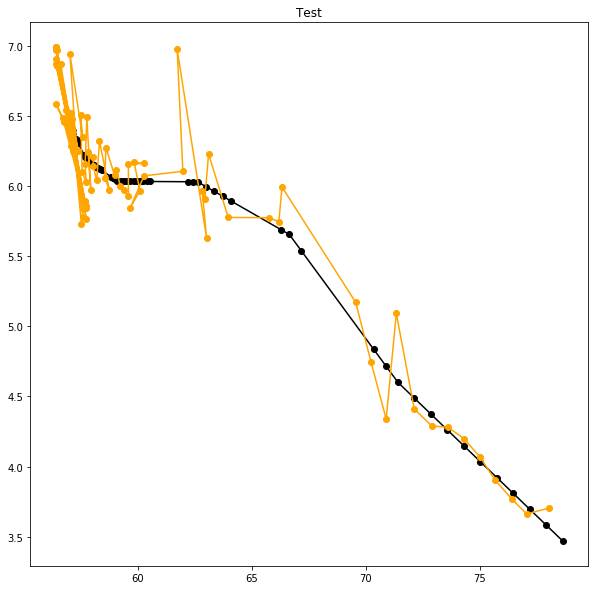

In [35]:
plot_route_df(routes[list(routes.keys())[i]])
i += 1

#### Run simple evaluation

In [36]:
def compute_error_route(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'error_x'] = (route['pred_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'error_y'] = (route['pred_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'error_angle'] = ((route['pred_angles']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['error_x'])
    y_e = np.mean(route['error_y'])
    a_e = np.mean(route['error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [39]:
def compute_error(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        trans, angle = compute_error_route(route)
        error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['error_trans'], eval_info['error_angle'] = error[:,0], error[:,1]
    # Remember that -2 in the routes index? The first route had 0 points so
    # it is a NaN. TODO: Investigate this
    #eval_info = eval_info.drop([0], axis=0)
    
    trans_error = np.mean(eval_info['error_trans'])
    angle_error = np.mean(eval_info['error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [40]:
compute_error(eval_info, routes)

RMSE trans: 0.17511024171409081
RMSE angle: 197.21943474117137


(0.17511024171409081, 197.21943474117137)

#### Run KF on single table

In [45]:
def run_kf_predictions(route):
    """ Runs Kalman Filter on the predictions 
        Params:
        -
        -
    """
    # Tracker object initialization
    position = route.iloc[0,0:3].values
    tracker = KalmanMotionTracker(position)
    
    # Container for the KF data
    kf = np.zeros((route.shape[0],3))
    kf[0,:] = route.iloc[0,0:3]
    # We feed from 0 to N observations to the filter
    for i in range(1, route.shape[0]):
        position = route.iloc[i,0:3].values
        tracker.update(position)
        # We store the inmediate pose
        #predictions = tracker.predict().ravel()
        predictions = tracker.get_state()
        kf[i,:] = predictions[:3]
        
    return kf

In [84]:
for i in range(len(routes)):
    
    route = routes[list(routes.keys())[i]]
    
    kf_pred = run_kf_predictions(route)
    
    route[['kf_trans_x','kf_trans_y', 'kf_angle']] = pd.DataFrame(kf_pred, index=route.index)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:2960: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [115]:
def plot_route_df_kf(name, routes, eval_info):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    route = routes[name]
    route_info = eval_info.loc[eval_info['name'] == name]
    nn_rmse = route_info['error_trans'].values[0]
    kf_rmse = route_info['kf_error_trans'].values[0]
    
    plt.plot(route['gt_pc1centers_x'], route['gt_pc1centers_y'], '-ok',color='black')
    plt.plot(route['gt_pc1centers_x']+route['pred_trans_x'], route['gt_pc1centers_y']+route['pred_trans_y'], '-ok', color='orange')
    plt.plot(route['gt_pc1centers_x']+route['kf_trans_x'], route['gt_pc1centers_y']+route['kf_trans_y'], '-ok', color='red')
    plt.title(f"route: {name} \t nn_rmse: {nn_rmse:.4f} \t              kf_rmse: {kf_rmse:.4f}", size=20)

/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/usuario/.conda/envs/thesis/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


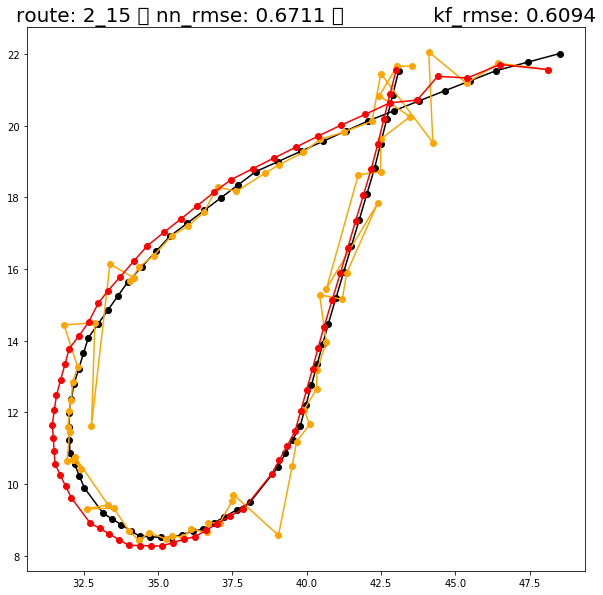

In [122]:
plot_route_df_kf(list(routes.keys())[i], routes, eval_info)
i += 1

#### Run simple evaluation again

In [70]:
def compute_error_route_kf(route):    
    """ Computes the RMSE for translation and angle """
    # squared
    route.loc[:,'kf_error_x'] = (route['kf_trans_x']-route['gt_trans_x'])**2
    route.loc[:,'kf_error_y'] = (route['kf_trans_y']-route['gt_trans_y'])**2
    route.loc[:,'kf_error_angle'] = ((route['kf_angle']-route['gt_angles'])*180)**2
    # mean
    x_e = np.mean(route['kf_error_x'])
    y_e = np.mean(route['kf_error_y'])
    a_e = np.mean(route['kf_error_angle'])
    # root
    trans = (x_e+y_e)**0.5
    angle = a_e**0.5
    
    #print(f"RMSE Trans: {trans}\nRMSE Angle: {angle}")
    
    return trans, angle

In [91]:
def compute_error_kf(eval_info, routes):
    """ Computer error over all routes
        Params:
        TBC
    """
    # Array declaration
    error = np.zeros((eval_info.shape[0],2))
    # For each route compute error and store it to array
    for i, route in enumerate(routes.values()):
        # This is bc there are some routes without the kf columns
        if route.shape[0] == 0:
            error[i,:] = [np.nan, np.nan]
        else:
            trans, angle = compute_error_route_kf(route)
            error[i,:] = [trans, angle]
    
    # Pass info from np.arrays to dataframe
    eval_info['kf_error_trans'], eval_info['kf_error_angle'] = error[:,0], error[:,1]
    
    
    trans_error = np.mean(eval_info['kf_error_trans'])
    angle_error = np.mean(eval_info['kf_error_angle'])
    
    print(f"RMSE trans: {trans_error}\nRMSE angle: {angle_error}")
    
    return trans_error, angle_error

In [92]:
compute_error_kf(eval_info, routes)

RMSE trans: 0.18568471524753094
RMSE angle: 276.2050700614799


(0.18568471524753094, 276.2050700614799)

#### Kalman filter implementation

In [43]:
class KalmanMotionTracker(object):
    """
    This class represents the internal state of individual tracked objects observed as translation.
    """
    def __init__(self, position):
        """
        Initialises a tracker using initial position.

        KF Instance variables:
          x : ndarray (dim_x, 1), default = [0,0,0…0] filter state estimate
          P : ndarray (dim_x, dim_x), default eye(dim_x) covariance matrix
          Q : ndarray (dim_x, dim_x), default eye(dim_x) Process uncertainty/noise
          R : ndarray (dim_z, dim_z), default eye(dim_x) measurement uncertainty/noise
          H : ndarray (dim_z, dim_x) measurement function
          F : ndarray (dim_x, dim_x) state transistion matrix
          B : ndarray (dim_x, dim_u), default 0 control transition matrix
        """
        #define constant velocity model
        self.kf = KalmanFilter(dim_x=5, dim_z=3)   

        self.kf.x[:3] = position.reshape((3, 1))
        self.kf.P[3:,3:] *= 1000. #state uncertainty, give high uncertainty to the unobservable initial velocities, covariance matrix
        self.kf.P *= 10.
        self.kf.Q[3:,3:] *= 0.01


        self.kf.F = np.array([[1,0,0,1,0],      # state transition matrix
                              [0,1,0,0,1],
                              [0,0,1,0,0],
                              [0,0,0,1,0],  
                              [0,0,0,0,1]])

        self.kf.H = np.array([[1,0,0,0,0],      # measurement function,
                              [0,1,0,0,0],
                              [0,0,1,0,0]])


        # self.kf.R[0:,0:] *= 10.   # measurement uncertainty

        self.time_since_update = 0
        self.history = []
        self.hits = 1           # number of total hits including the first detection
        self.hit_streak = 1     # number of continuing hit considering the first detection
        self.first_continuing_hit = 1
        self.still_first = True
        self.age = 0

    def update(self, position): 
        """ 
        Updates the state vector with observed position.
        """
        self.time_since_update = 0
        self.history = []
        self.hits += 1
        self.hit_streak += 1          # number of continuing hit
        if self.still_first:
            self.first_continuing_hit += 1      # number of continuing hit in the fist time

        ######################### orientation correction NEEDED?
        if self.kf.x[2] >= np.pi: self.kf.x[2] -= np.pi * 2    # make the theta still in the range
        if self.kf.x[2] < -np.pi: self.kf.x[2] += np.pi * 2

        new_theta = position[2]
        if new_theta >= np.pi: new_theta -= np.pi * 2    # make the theta still in the range
        if new_theta < -np.pi: new_theta += np.pi * 2
        position[2] = new_theta

        predicted_theta = self.kf.x[2]
        if abs(new_theta - predicted_theta) > np.pi / 2.0 and abs(new_theta - predicted_theta) < np.pi * 3 / 2.0:     # if the angle of two theta is not acute angle
            self.kf.x[2] += np.pi       
            if self.kf.x[2] > np.pi: self.kf.x[3] -= np.pi * 2    # make the theta still in the range
            if self.kf.x[2] < -np.pi: self.kf.x[3] += np.pi * 2

        # now the angle is acute: < 90 or > 270, convert the case of > 270 to < 90
        if abs(new_theta - self.kf.x[2]) >= np.pi * 3 / 2.0:
            if new_theta > 0: self.kf.x[2] += np.pi * 2
            else: self.kf.x[2] -= np.pi * 2

        #########################

        self.kf.update(position)

        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2    # make the theta still in the range
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

    def predict(self):       
        """
        Advances the state vector and returns the predicted movement estimate.
        """
        self.kf.predict()      
        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

        self.age += 1
        if(self.time_since_update>0):
            self.hit_streak = 0
            self.still_first = False
        self.time_since_update += 1
        self.history.append(self.kf.x)
        
        return self.history[-1]

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return self.kf.x[:3].reshape((3, ))